In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error as MSE, log_loss,r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATA_PATH = "/content/drive/MyDrive/WaterPollution/waterPollution.csv"

In [4]:
data = pd.read_csv(DATA_PATH)

In [4]:
data.head()

,parameterWaterBodyCategory,observedPropertyDeterminandCode,procedureAnalysedFraction,procedureAnalysedMedia,resultUom,phenomenonTimeReferenceYear,parameterSamplingPeriod,resultMeanValue,waterBodyIdentifier,Country,PopulationDensity,TerraMarineProtected_2016_2018,TouristMean_1990_2020,VenueCount,netMigration_2011_2018,droughts_floods_temperature,literacyRate_2010_2018,combustibleRenewables_2009_2014,gdp,composition_food_organic_waste_percent,composition_glass_percent,composition_metal_percent,composition_other_percent,composition_paper_cardboard_percent,composition_plastic_percent,composition_rubber_leather_percent,composition_wood_percent,composition_yard_garden_green_waste_percent,waste_treatment_recycling_percent
0,RW,CAS_14797-65-0,total,water,mg{NO2}/L,2009,2009-01--2009-12,0.063310,FRDR609,France,122.299437,30.831906,71176346.0,0.0,75808.375,0.005718,0.000000,4.457840,2.806036e+12,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,0.0,22.26
1,RW,CAS_14797-65-0,total,water,mg{NO2}/L,2009,2009-01--2009-12,0.046733,FRFR238,France,122.299437,30.831906,71176346.0,0.0,75808.375,0.005718,0.000000,4.457840,2.806036e+12,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,0.0,22.26
2,RW,EEA_3164-07-6,total,water,{massRatio},2009,2009-01--2009-12,132.859000,FRFR238,France,122.299437,30.831906,71176346.0,0.0,75808.375,0.005718,0.000000,4.457840,2.806036e+12,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,0.0,22.26
3,RW,CAS_14797-55-8,total,water,mg{NO3}/L,2009,2009-01--2009-12,11.578376,FRFR327C,France,122.299437,30.831906,71176346.0,2.0,75808.375,0.005718,0.000000,4.457840,2.806036e+12,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,0.0,22.26
4,RW,EEA_3151-01-7,total,water,mmol/L,2009,2009-01--2009-12,0.206800,ES014MSPFES-014-NR-038-000-02-02,Spain,93.677197,15.047884,50941692.0,4.0,-40055.250,0.729194,87.158924,4.363288,1.464509e+12,49.0,8.0,3.0,14.0,15.0,9.0,0.0,2.0,0.0,16.84


In [37]:
data.isna().sum()

parameterWaterBodyCategory                     0
observedPropertyDeterminandCode                0
procedureAnalysedFraction                      0
procedureAnalysedMedia                         0
resultUom                                      0
phenomenonTimeReferenceYear                    0
parameterSamplingPeriod                        0
resultMeanValue                                0
waterBodyIdentifier                            0
Country                                        0
PopulationDensity                              0
TerraMarineProtected_2016_2018                 0
TouristMean_1990_2020                          0
VenueCount                                     0
netMigration_2011_2018                         0
droughts_floods_temperature                    0
literacyRate_2010_2018                         0
combustibleRenewables_2009_2014                0
gdp                                            0
composition_food_organic_waste_percent         0
composition_glass_pe

In [5]:
data.dropna(axis=0,inplace=True)

In [6]:
columns = ("parameterWaterBodyCategory","observedPropertyDeterminandCode","procedureAnalysedFraction","procedureAnalysedMedia","resultUom","parameterSamplingPeriod","waterBodyIdentifier","Country")
for i in columns:
  le = LabelEncoder()
  data[i] = le.fit_transform(data[i])

In [6]:
x = data.drop(["resultMeanValue"],axis = 1)
y = data["resultMeanValue"].values

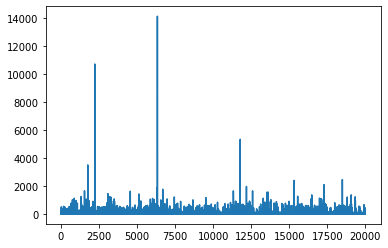

In [7]:
data["resultMeanValue"].plot()

# Classification

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)

In [10]:
def makeClass(y):
  y = ["Dirty" if x > 500 else "Clean" for x in y]
  return y

In [11]:
y_train, y_test = makeClass(y_train),makeClass(y_test)

In [12]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [13]:
def createModels():
  xgBoost = xg.XGBClassifier()
  knn = KNeighborsClassifier()
  svc = SVC(probability=True)
  randomForest = RandomForestClassifier()
  adaBoost = AdaBoostClassifier()
  nb = GaussianNB()
  return ((xgBoost,"XGBoost Classifier"),(knn,"KNN Classifier"),(svc,"SVC Classifier"),(randomForest,"Random Forest Classifier"),(adaBoost,"AdaBoost Classifier"),(nb,"Naive Bayes Classifier"))

models = createModels()
for model,name in models:
  model.fit(x_train,y_train)
  print(f"Accuracy of {name}: {model.score(x_test,y_test)}")

Accuracy of XGBoost Classifier: 0.9892761394101877
Accuracy of KNN Classifier: 0.9877680965147453
Accuracy of SVC Classifier: 0.9867627345844504
Accuracy of Random Forest Classifier: 0.9906166219839142
Accuracy of AdaBoost Classifier: 0.9884383378016086
Accuracy of Naive Bayes Classifier: 0.6575067024128687


In [63]:
y_test = [0 if i == "Clean" else 1 for i in y_test]
for model,name in models:
  y_score = model.predict_proba(x_test)[:,1] 
  false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
  print(f'roc_auc_score for {name}: ', roc_auc_score(y_test, y_score))

roc_auc_score for XGBoost Classifier:  0.98899471445368
roc_auc_score for KNN Classifier:  0.9171390126625268
roc_auc_score for SVC Classifier:  0.9346367718402255
roc_auc_score for Random Forest Classifier:  0.9357792150566062
roc_auc_score for AdaBoost Classifier:  0.9836317872196823
roc_auc_score for Naive Bayes Classifier:  0.8351034217410277


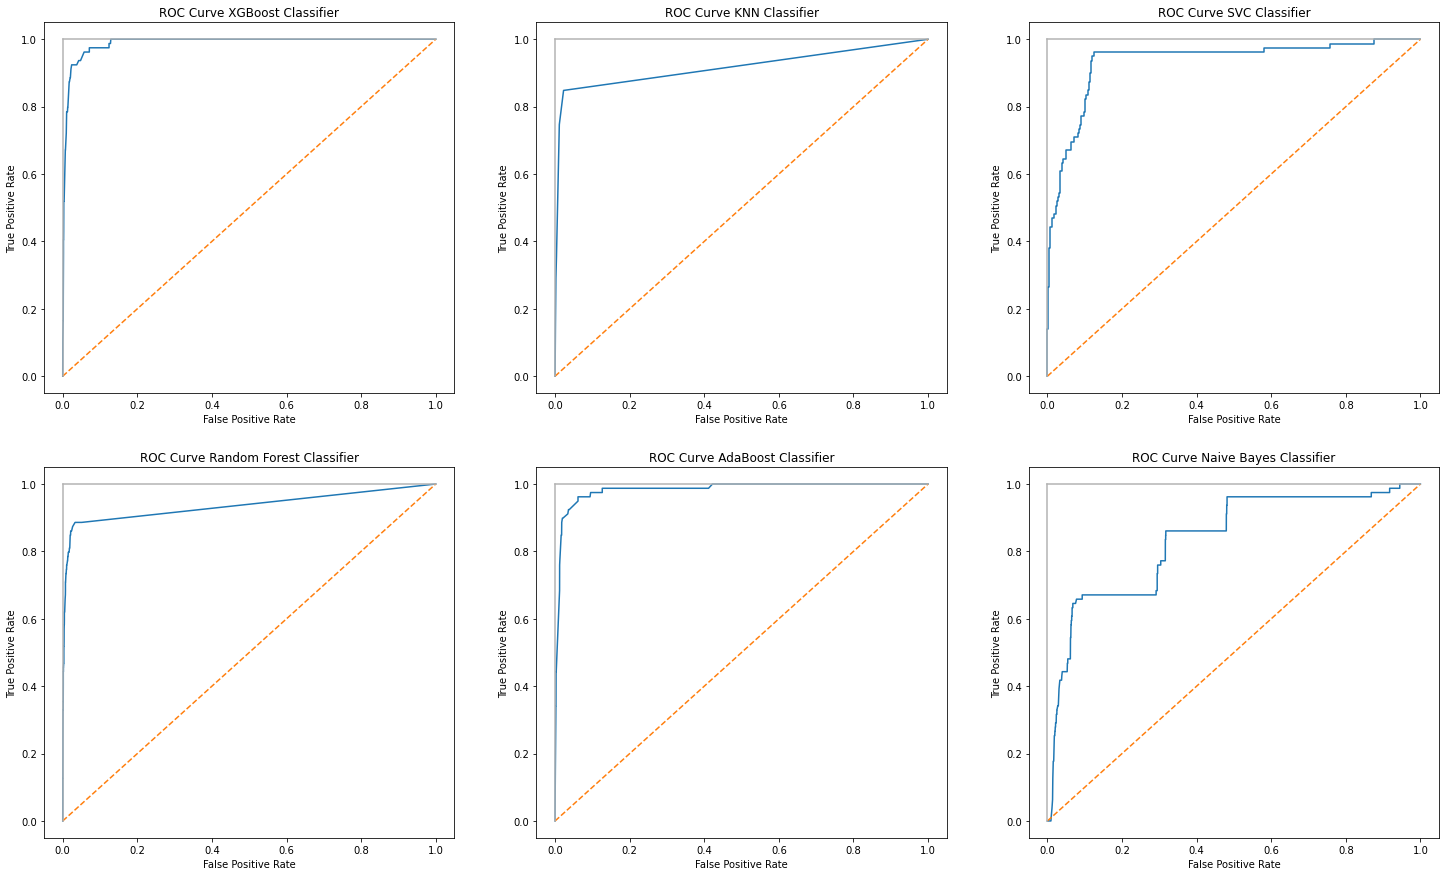

In [65]:
plt.subplots(nrows=2,ncols=3,figsize = (25,15))
figurePos = 1
for model,name in models:
  plt.subplot(2,3,figurePos)
  figurePos += 1
  y_score = model.predict_proba(x_test)[:,1] 
  false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
  plt.title(f"ROC Curve {name}")
  plt.plot(false_positive_rate, true_positive_rate)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
plt.show()

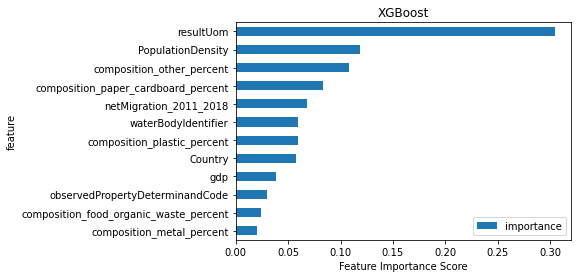

In [33]:
features = np.concatenate([data.columns[:7],data.columns[8:]])

model = xg.XGBClassifier()
model.fit(x_train,y_train)
feat_imp = pd.DataFrame({'importance':model.feature_importances_})    
feat_imp['feature'] = features
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:12]   
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="XGBoost")
plt.xlabel('Feature Importance Score')
plt.show()

# Regression

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)

In [75]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [78]:
regressor = xg.XGBRegressor()\
            .fit(x_train,y_train)

[16:19:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [80]:
preds = regressor.predict(x_test)

In [90]:
preds

array([ 5.3780212, 10.801078 , 33.023285 , ..., 11.360363 ,  2.9558618,
        2.8762481], dtype=float32)

In [86]:
mse = MSE(y_test,preds)
r2Score = r2_score(y_test,preds)

In [89]:
print("Metrics for XGBoost Regressor")
print(f"MSE: {mse}\nRMSE: {mse ** (1/2)}\nR^2 Score: {r2Score}")

Metrics for XGBoost Regressor
MSE: 26658.278980488074
RMSE: 163.27363222666443
R^2 Score: 0.14316101172408313


# Run Classifier By Features

In [10]:
model = KNeighborsClassifier()

y = data["resultMeanValue"].values
x = data.drop(["resultMeanValue"],axis = 1)

def makeClass(y):
  y = ["Dirty" if x > 500 else "Clean" for x in y]
  return y


def fitData(x,y,model,columns):
  a = x[columns]
  x_train,x_test,y_train,y_test = train_test_split(a,y,test_size = 0.3,random_state=42)
  y_train, y_test = makeClass(y_train),makeClass(y_test)
  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.fit_transform(x_test)
  model.fit(x_train,y_train)
  return model.score(x_test,y_test)

usedCols = list()
scores = list()
for col in x.columns:
  usedCols.append(col)
  score = fitData(x,y,model,usedCols)
  scores.append(score)
  print(f"Accuracy with {col} Feature: {score}")
  print("-"*65)


Accuracy with parameterWaterBodyCategory Feature: 0.9867627345844504
-----------------------------------------------------------------
Accuracy with observedPropertyDeterminandCode Feature: 0.9874329758713136
-----------------------------------------------------------------
Accuracy with procedureAnalysedFraction Feature: 0.9874329758713136
-----------------------------------------------------------------
Accuracy with procedureAnalysedMedia Feature: 0.9874329758713136
-----------------------------------------------------------------
Accuracy with resultUom Feature: 0.9874329758713136
-----------------------------------------------------------------
Accuracy with phenomenonTimeReferenceYear Feature: 0.9870978552278821
-----------------------------------------------------------------
Accuracy with parameterSamplingPeriod Feature: 0.9874329758713136
-----------------------------------------------------------------
Accuracy with waterBodyIdentifier Feature: 0.9865951742627346
------------

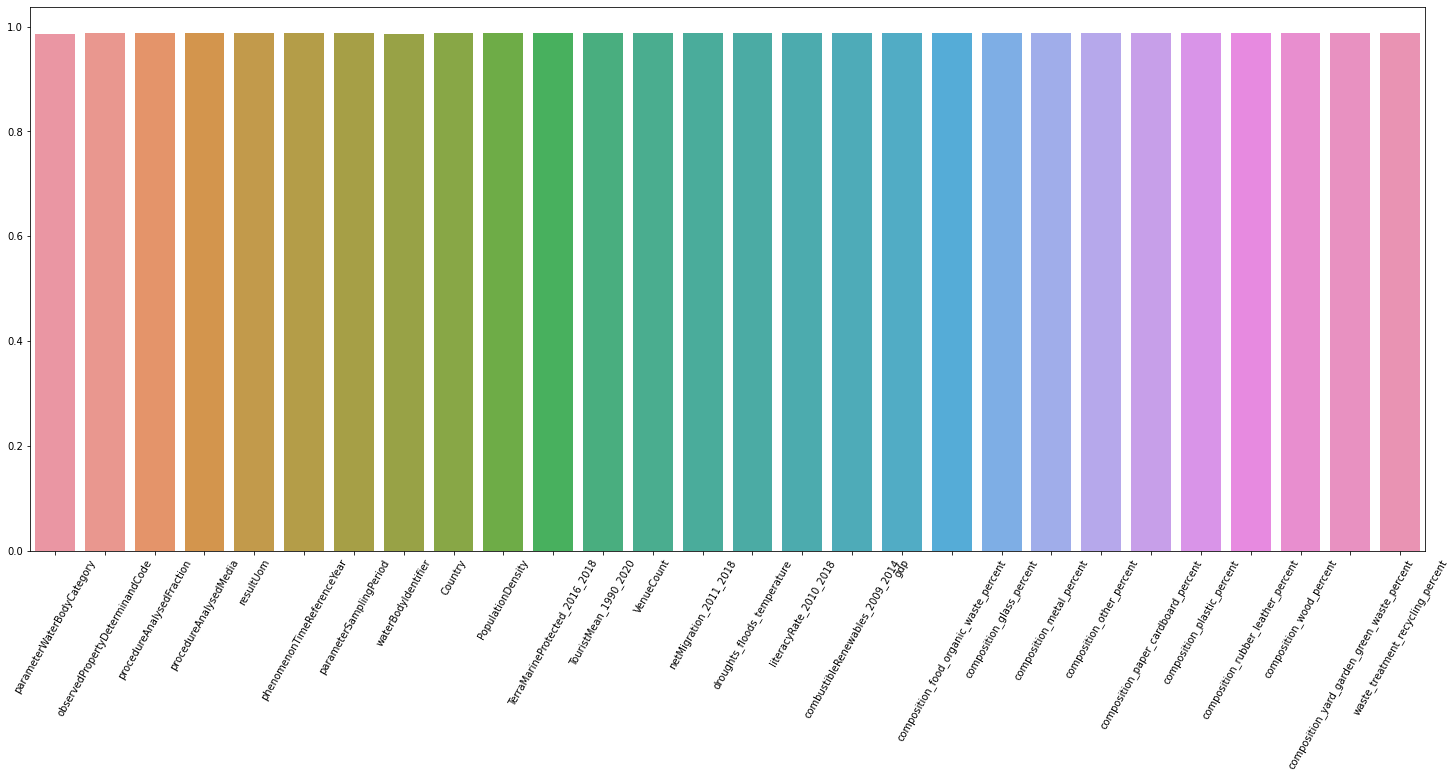

In [23]:
plt.figure(figsize=(25,10))
sns.barplot(x=usedCols,y=scores)
plt.xticks(rotation=60)
plt.show()